In [ ]:
# %pip install torch
# %pip install tensorflow
# %pip install opencv-python
# %pip install numpy
# %pip install matplotlib

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# X_train_path = "DOTAv1\\images\\train"
# Y_train_path = "DOTAv1\\labels\\train"
# X_val_path = "DOTAv1\\images\\val"
# Y_val_path = "DOTAv1\\labels\\val"
# X_test_path = "DOTAv1\\images\\test"

# X_train = os.listdir(X_train_path)
# Y_train = os.listdir(Y_train_path)


# X_val = os.listdir(X_val_path)
# Y_val = os.listdir(Y_val_path)
# X_test = os.listdir(X_test_path)
# # print(len(X_train), len(Y_train))
# # print(len(X_val), len(Y_val))
# # print(len(X_test))

# print(len(X_train))
# print(len(Y_train))

input_folder = "DOTAv1\\images\\train"
output_folder = "DOTAv1\\preprocessed_images\\train"
input_labels_folder = "DOTAv1\\labels\\train"
output_labels_folder = "DOTAv1\\preprocessed_labels\\train"


In [3]:
input_folder = "DOTAv1\\images\\train"
output_folder = "DOTAv1\\preprocessed_images\\train"
input_labels_folder = "DOTAv1\\labels\\train"
output_labels_folder = "DOTAv1\\preprocessed_labels\\train"

os.makedirs(output_folder, exist_ok=True)
# os.makedirs(output_labels_folder, exist_ok=True)

def resize_image(input_path, output_path, target_size=(400, 400)):
    try:
        img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        previous_size = img.shape[0]

        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        resized_img = resized_img.reshape((400, 400, 1))
        # resized_img = resized_img.astype(np.float32) / 255.0
        cv2.imwrite(output_path, resized_img)
        print(resized_img.shape)
        
        # print(f"Processed {input_path} and {input_label_path}")
    
    except Exception as e:
        print(f"Error processing {input_path}: {e}")



In [ ]:
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)
        label_file_name = filename.replace(".jpg", ".txt")
        input_label_path = os.path.join(input_labels_folder, label_file_name)
        output_label_path = os.path.join(output_labels_folder, label_file_name)
        
        resize_image(input_path, output_path)

In [5]:
def data_load(output_folder, input_labels_folder):
    X = []
    Y = []
    
    # Determine the maximum number of labels
    max_labels = 0
    for file in os.listdir(output_folder):
        if file.endswith('.jpg'):
            label_file = file.replace('.jpg', '.txt')
            label_path = os.path.join(input_labels_folder, label_file)
            
            with open(label_path, 'r') as f:
                lines = f.readlines()
                max_labels = max(max_labels, len(lines))
    
    for file in os.listdir(output_folder):
        if file.endswith('.jpg'):
            img_path = os.path.join(output_folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img.astype(np.float32) / 255.0 

            label_file = file.replace('.jpg', '.txt')
            label_path = os.path.join(input_labels_folder, label_file)
            
            # Initialize with class 15 and coordinates as 0
            labels = np.zeros((max_labels, 9), dtype=np.float32)
            labels[:, 0] = 15  # Set class to 15 for all rows
            
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for i, line in enumerate(lines):
                    if i >= max_labels:
                        break
                    parts = line.strip().split()
                    labels[i] = np.array(parts, dtype=np.float32)
            
            X.append(img)
            Y.append(labels)
    
    X = np.array(X)
    print(f"Number of images: {len(X)}")
    X = np.expand_dims(X, axis=-1)  # Add channel dimension
    Y = np.array(Y)
    
    # Convert to TensorFlow tensors
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    
    return dataset, max_labels



In [6]:
# Usage
dataset, max_labels = data_load(output_folder, input_labels_folder)

# You can then use this dataset directly or apply further transformations

# Example of checking the dataset
for image, labels in dataset.take(1):
    print("Image shape:", image.shape)
    print("Labels shape:", labels.shape)
    print("Sample labels:")
    print(pd.DataFrame(labels).tail())

Number of images: 1411
Image shape: (400, 400, 1)
Labels shape: (1939, 9)
Sample labels:
         0    1    2    3    4    5    6    7    8
1934  15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1935  15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1936  15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1937  15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1938  15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [ ]:
# model = tf.keras.Model(inputs = inputs, outputs = ["classifier_head", "regressor_head"])
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.image as mpimg
import os
image = os.path.join(output_folder, os.listdir(output_folder)[0])
img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

text_file = os.listdir(output_folder)[0].replace(".jpg", ".txt")

coords_x = []
coords_y = []
with open(os.path.join(input_labels_folder, text_file), "r") as f:
    line = f.readlines()[0]
    line = line.split()
    label = line[0]
    coords_x = [float(elt) * 800 for elt in line[1:9:2]]
    coords_y = [float(elt) * 800 for elt in line[2:9:2]]

print(label, coords_x, coords_y)


# Define the coordinates of the polygon

points = list(zip(coords_x, coords_y))

# Load the image
image_path = image  # Replace with your image path
img = mpimg.imread(image_path)

# Create a new figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create the polygon and add it to the plot
polygon = Polygon(points, closed=True, fill=None, edgecolor='r', linewidth=2)
ax.add_patch(polygon)

# Set the x and y axis limits to show the entire image
ax.set_xlim(0, img.shape[1])
ax.set_ylim(img.shape[0], 0)

# Show the plot
plt.show()

In [9]:
def one_hot_encoding(image, labels, max_labels, num_classes=16):
    class_ids = tf.cast(labels[:, 0], tf.int32)
    valid_mask = tf.not_equal(class_ids, num_classes - 1)
    one_hot_classes = tf.one_hot(class_ids, num_classes)
    bounding_boxes = tf.where(
        tf.expand_dims(valid_mask, -1),
        labels[:, 1:],
        tf.zeros_like(labels[:, 1:])
    )
    return image, (one_hot_classes, bounding_boxes)


def tune_training_ds(dataset, batch_size=16):
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat()  # The dataset will be repeated indefinitely.
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Assume dataset and max_labels are obtained from data_load function
dataset, max_labels = data_load(output_folder, input_labels_folder)

# Apply the one-hot encoding to the dataset
one_hot_encoded_dataset = dataset.map(
    lambda x, y: one_hot_encoding(x, y, max_labels=max_labels, num_classes=16)
)

# Prepare the final training dataset
train_dataset = tune_training_ds(one_hot_encoded_dataset)

# Print information about the dataset
for image, labels in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("One-hot encoded classes shape:", labels[0].shape)
    print("Bounding boxes shape:", labels[1].shape)
    print("First one-hot encoded class:", labels[0][0][0])
    print("First bounding box:", labels[1][0].shape)

print(train_dataset)

Number of images: 1411
Image shape: (16, 400, 400, 1)
One-hot encoded classes shape: (16, 1939, 16)
Bounding boxes shape: (16, 1939, 8)
First one-hot encoded class: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(16,), dtype=float32)
First bounding box: (1939, 8)
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 400, 1), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1939, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1939, 8), dtype=tf.float32, name=None)))>


In [ ]:
valid_input_images = "DOTAv1\\images\\val"
valid_output_images = "DOTAv1\\preprocessed_images\\val"

os.makedirs(valid_output_images, exist_ok=True)

for file in os.listdir(valid_input_images):
    filepath = os.path.join(valid_input_images, file)
    output_path = os.path.join(valid_output_images, file)
    resize_image(filepath, output_path)


In [ ]:
validation_labels_folder = "DOTAv1\\labels\\val"

validation_dataset, max_labels_v = data_load(valid_output_images, validation_labels_folder)

for image, labels in validation_dataset.take(1):
    print("Image shape", image.shape)
    print("Label shape : ", labels.shape)
    print("Sample labels:")
    print(pd.DataFrame(labels).tail())

In [ ]:
one_hot_encoded_validation = validation_dataset.map(lambda x, y: one_hot_encoding(x, y, num_classes=15, max_labels=max_labels))
Validation_dataset = tune_training_ds(one_hot_encoded_validation)
for image, labels in Validation_dataset.take(1):
    print("Image shape:", image.shape)
    print("Labels shape:", labels[0].shape, labels[1].shape)
    # print("First label:", labels[0, 0])
    print("Labels length: ", len(labels))


In [10]:
def build_regressor(inputs):

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(400, 400, 1))(inputs)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(128, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(256, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    
    x = tf.keras.layers.Dense(units = 8, name="regressor_head")(x)

    return x

In [11]:
no_of_classes = 15

def build_classifier(inputs):
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(400, 400, 1), padding="same")(inputs)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(128, kernel_size=3, activation = 'relu', padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(256, kernel_size=3, activation = 'relu', padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(128, kernel_size=3, activation = 'relu', padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation = 'relu')(x)

    x = tf.keras.layers.Dense(no_of_classes, activation='softmax', name="classifier_head")(x)

    return x

In [12]:
def build_model(inputs):
    classification_head = build_classifier(inputs)
    regressor_head = build_regressor(inputs)
    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss={"classifier_head" : "categorical_crossentropy", "regressor_head" : "mse"}, metrics = {"classifier_head" : "accuracy", "regressor_head" : "mse"})
    return model

In [13]:
model = build_model(tf.keras.layers.Input(shape=(400, 400, 1)))
model.summary()

C:\Users\adity\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 160000)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 160000)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │ 10,240,064 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │ 10,240,064 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_head     │ (None, 15)        │        975 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regressor_head      │ (None, 8)         │        520 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,481,623 (78.13 MB)

 Trainable params: 20,481,623 (78.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# def build_shared_layers(inputs):
#     x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding="same")(inputs)
#     x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    
#     x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding="same")(x)
#     x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    
#     x = tf.keras.layers.Flatten()(x)
#     return x

# def build_model(input_shape, num_classes=16, max_labels=1939):
#     inputs = tf.keras.layers.Input(shape=input_shape)
#     shared_features = build_shared_layers(inputs)
    
#     classification_output = tf.keras.layers.Dense(max_labels * num_classes)(shared_features)
#     classification_output = tf.keras.layers.Reshape((max_labels, num_classes))(classification_output)
#     classification_output = tf.keras.layers.Activation('softmax', name='classification')(classification_output)
    
#     bbox_output = tf.keras.layers.Dense(max_labels * 8)(shared_features)
#     bbox_output = tf.keras.layers.Reshape((max_labels, 8), name='bbox')(bbox_output)
    
#     model = tf.keras.Model(inputs=inputs, outputs=[classification_output, bbox_output])
    
#     return model

# # def classification_loss(y_true, y_pred):
# #     return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred))

# # # Define the bounding box regression loss
# # def bbox_regression_loss(y_true, y_pred):
# #     return tf.reduce_mean(tf.keras.losses.mean_squared_error(y_true, y_pred))

# # def classification_accuracy(y_true, y_pred):
# #     y_true_class, _ = tf.split(y_true, [num_classes, -1], axis=-1)
# #     y_pred_class, _ = tf.split(y_pred, [num_classes, -1], axis=-1)
    
# #     return tf.keras.metrics.categorical_accuracy(y_true_class, y_pred_class)

# # def bbox_mse(y_true, y_pred):
# #     _, y_true_bbox = tf.split(y_true, [num_classes, -1], axis=-1)
# #     _, y_pred_bbox = tf.split(y_pred, [num_classes, -1], axis=-1)
    
# #     return tf.keras.metrics.mean_squared_error(y_true_bbox, y_pred_bbox)

# # # Combine the losses
# # def combined_loss(y_true, y_pred):
# #     print(y_true.shape)
# #     print(y_pred.shape)
# #     y_true_class, y_true_bbox = y_true
# #     y_pred_class, y_pred_bbox = y_pred
    
# #     class_loss = classification_loss(y_true_class, y_pred_class)
# #     bbox_loss = bbox_regression_loss(y_true_bbox, y_pred_bbox)
    
# #     total_loss = class_loss + bbox_loss
# #     return total_loss


In [14]:
# model = build_model((400, 400, 1))
# model.summary()
# image_path = "DOTAv1\\preprocessed_images\\train\\P0000.jpg"
# img = cv2.imread(image_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# # Your existing code for prediction
# img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# img_gray = img_gray.astype(np.float32) / 255.0
# img_gray = np.expand_dims(img_gray, axis=(0, -1))
# output1, output2 =  model(img_gray)
# print(output1, output2)
# Compile the model
model = build_model((400, 400, 1))
model.compile(optimizer='adam', 
                   loss={'classification': 'categorical_crossentropy', 'bbox': 'mse'},
                   loss_weights={'classification': 1.0, 'bbox': 1.0})
history = model.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=1,
    verbose=True # Adjust based on your dataset size
    # validation_data=validation_dataset,  # If you have a validation dataset
    # validation_steps=50  # Adjust based on your validation dataset size
)

C:\Users\adity\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 400 (of type <class 'int'>)

In [ ]:
# def process_dataset(dataset):
#     # Separate the elements of the dataset
#     def separate_elements(element, index):
#         images = element[0]  # Shape: (None, 400, 400, 1)
#         output1 = element[1][0]  # Shape: (None, 1939, 16)
#         output2 = element[1][1]  # Shape: (None, 1939, 8)
#         return images, output1, output2

#     # Use map to apply the separation to each element in the dataset
#     processed_dataset = dataset.map(separate_elements, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#     # Convert the processed dataset into three separate datasets
#     train_x = processed_dataset.map(lambda x, y, z: x, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#     output1 = processed_dataset.map(lambda x, y, z: y, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#     output2 = processed_dataset.map(lambda x, y, z: z, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#     return train_x, output1, output2

# # Apply the processing to your dataset
# train_x, output1, output2 = process_dataset(train_dataset)

# print(train_x, output1, output2)


In [7]:
def process_dataset(dataset):
    # Separate the elements of the dataset
    def separate_elements(element, index):
        images = element[0]  # Shape: (None, 400, 400, 1)
        output1 = element[1][0]  # Shape: (None, 1939, 16)
        output2 = element[1][1]  # Shape: (None, 1939, 8)
        return images, {'output1': output1, 'output2': output2}

    # Use map to apply the separation to each element in the dataset
    processed_dataset = dataset.map(separate_elements, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return processed_dataset

# Apply the processing to your dataset
processed_train_dataset = process_dataset(train_dataset)

# Now, train your model using the processed dataset
history = model.fit(
    processed_train_dataset,
    epochs=100,
    steps_per_epoch=1,
    verbose=True # Adjust based on your dataset size
    # validation_data=validation_dataset,  # If you have a validation dataset
    # validation_steps=50  # Adjust based on your validation dataset size
)

print(history)


Epoch 1/100


C:\Users\adity\AppData\Roaming\Python\Python311\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'bias', 'gamma', 'beta', 'bias', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 45.8662
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step - loss: 38.7514
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step - loss: 32.5008
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step - loss: 27.0921
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step - loss: 22.4712
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step - loss: 18.5738
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step - loss: 15.3311
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step - loss: 12.6717
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step - loss: 10.5242
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step - loss: 8.8185
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step - loss: 7.4877
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step - loss: 6.4682
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step - loss: 5.7016
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step - loss: 5.1346
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step - loss: 4.7202
Epoch 16/1

In [10]:
print(history.history.keys())

dict_keys(['loss'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
Class ID: 4
-1.12512325e-05 1.596832e-06 2.2498856e-05 -2.528318e-05 9.287865e-06 -3.3971624e-05 0.00013713514 -1.591105e-05


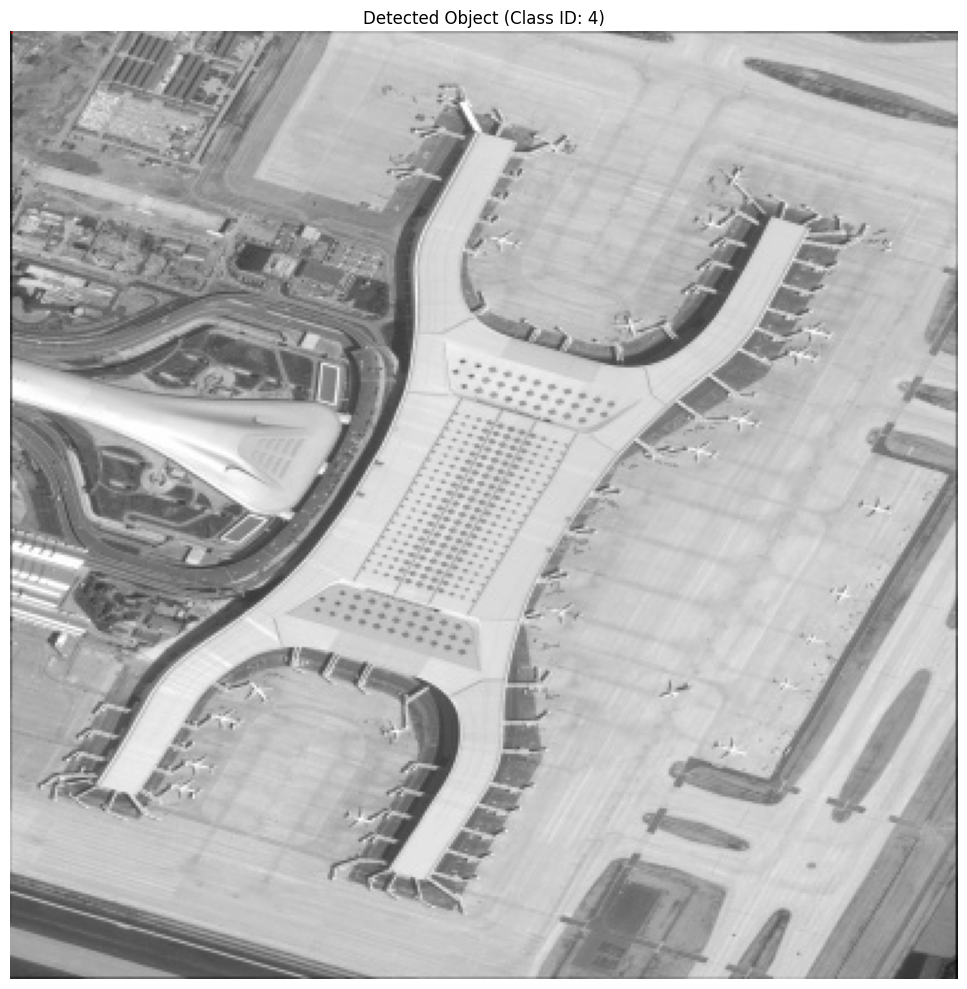

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Load and preprocess the image
image_path = "DOTAv1\\preprocessed_images\\train\\P0000.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Your existing code for prediction
img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img_gray = img_gray.astype(np.float32) / 255.0
img_gray = np.expand_dims(img_gray, axis=(0, -1))
predictions = model.predict(img_gray)
class_probs, bounding_boxes = predictions
class_id = np.argmax(class_probs[0][8])
print("Class ID:", class_id)

# Extract bounding box coordinates
bbox = bounding_boxes[0][8]
x1, y1, x2, y2, x3, y3, x4, y4 = bbox

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Display the image
ax.imshow(img)

print(x1 , y1, x2 , y2, x3 , y3 , x4 ,y4)
# Create a Polygon patch
polygon = Polygon([(x1*400, y1*400), (x2*400, y2*400), (x3*400, y3*400), (x4*400, y4*400)], 
                  closed=True, fill=False, edgecolor='r', linewidth=2)

# Add the polygon to the plot
ax.add_patch(polygon)

# Set the title
ax.set_title(f"Detected Object (Class ID: {class_id})")

# Remove axis labels
ax.set_axis_off()

# Show the plot
plt.tight_layout()
plt.show()